# Plane Detection Algorithm

## What it does

The Plane detection algorithm is designed to sort through rti data collected by Zephyr to identify planes in the data. Currently it is being designed to work in tandem with other mechanisms to automate the calibration of Zephyr.

## How it works

Before RTI data is used in detect_plane, it is first passed through reduce_xarray from the zephyr repository, which effectivly formats the data, and makes "peaks" from both planes and meteors more evident. Other methods of prep can also be used to prep data. Once passed into the detect_plane function, a CFAR algorithm is used across all range gates for each individual timestamp, and the targets are recorded. These targets are then fed into the DBSCAN clustering algorithm which is used to identify groups of target points which corelate to individual objects such as planes.

# Preliminary steps

This section addresses the topics of:
    1. Reading rti data from a .rti file
    2. Visualizing data
    3. Using functions from the Zephyr repository to prepare rti data for the plane detection algorithm.

First, RTI data must be loaded into the workspace from a file. In this example glob and pickle are used. Code for reading rti data files, and plots 

In [237]:
import glob # A common system tool for finding and parsing files 
data_dir = './rti_examples' # The name of the folder with the files 

In [238]:
import pickle # For loading files

file_name = 'RTI_Plane_2meteors.rti'
with open(f'{data_dir}/{file_name}', "rb") as f:
        rti_xarray = pickle.load(f)

Now the rti data has been loaded into the workspace as rti_xarray, with the type xarray data array (https://docs.xarray.dev/en/latest/generated/xarray.DataArray.pad.html), which is comperable to a numpy array (https://numpy.org/doc/2.1/reference/generated/numpy.array.html). It is simular to a numpy array, with additional functionality. In this case rti_xarray is a four dimentional array (gate,time, channel, dopler shift) with complex values. In this example the doppler shift only takes one value.

Once loaded, different tequniques can be used to prep the xarray for visualization or to be fed into the plane detection algorithm. In almost all cases, the complex values of the array must be converted to real values. This can be done using the numpy.abs  or simular functions. Failure to do so may not cause imediate issues, as many libraries will automatically convert complex values to real, but this can cause errors later on.
TODO: Add link to numpy.abs

First, plotting averageg rti data is shown below.

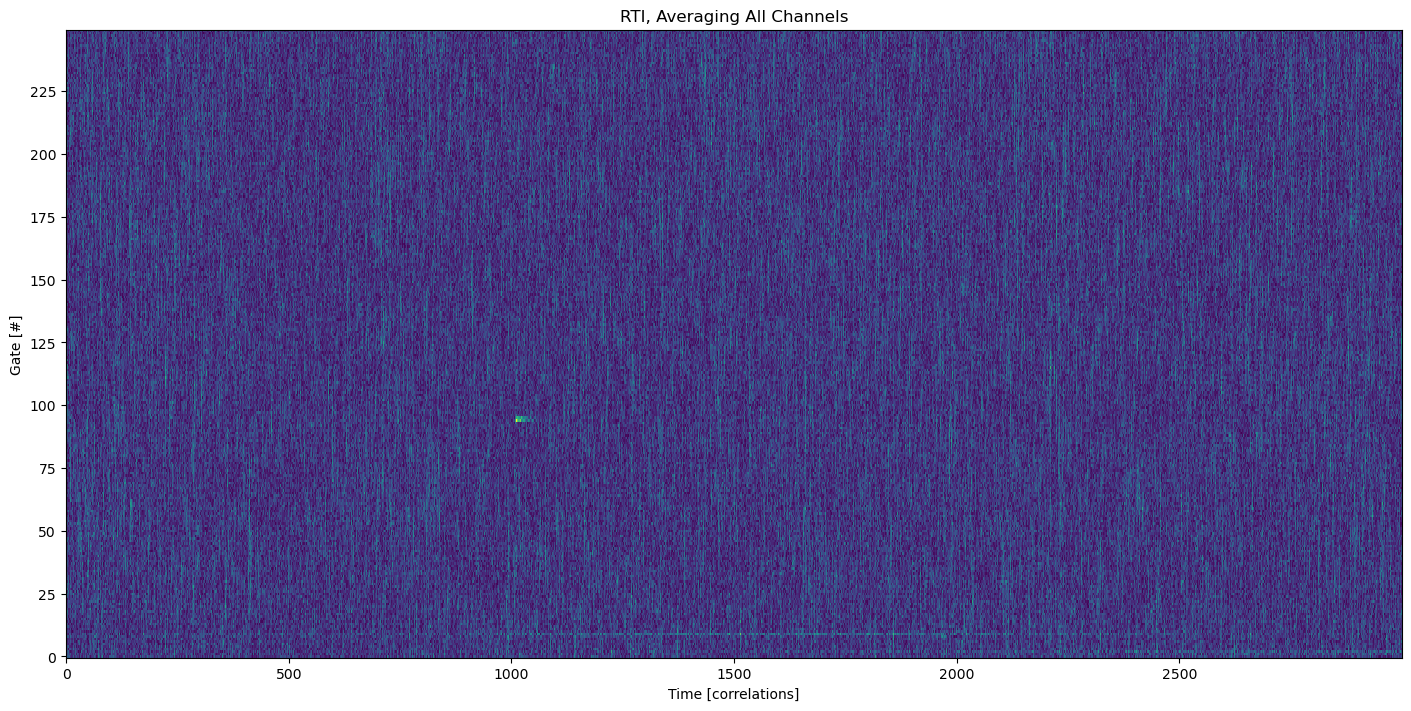

In [239]:
import numpy as np 
import matplotlib.pyplot as plt # Plotting 
from matplotlib.ticker import MaxNLocator

# RTI diagram
rti_array = rti_xarray.values[:, 0, :250, :]
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
rti_for_plot = np.abs(rti_array.mean(0))  # Collapse Doppler Dimension, mean across channels

ax.imshow(rti_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

This rti data includes one plane, and two meteors, however the plane is barely visible, and only one meteor is visible. This rti data which spans approximately 15s across 1000 gates (indexed at 0) has been reduced to only the first 250 gates, which is more than necesary to view meteors. Planes, are much lower maybe reaching gates 20 or 25, many still below gate 10. Note here that data should be fed into the plane detection whole, or indexing values will be wrong.

For a clearer view,  a PCA algorithm can be used. (
)
TODO: link to PCA

(750000, 1)


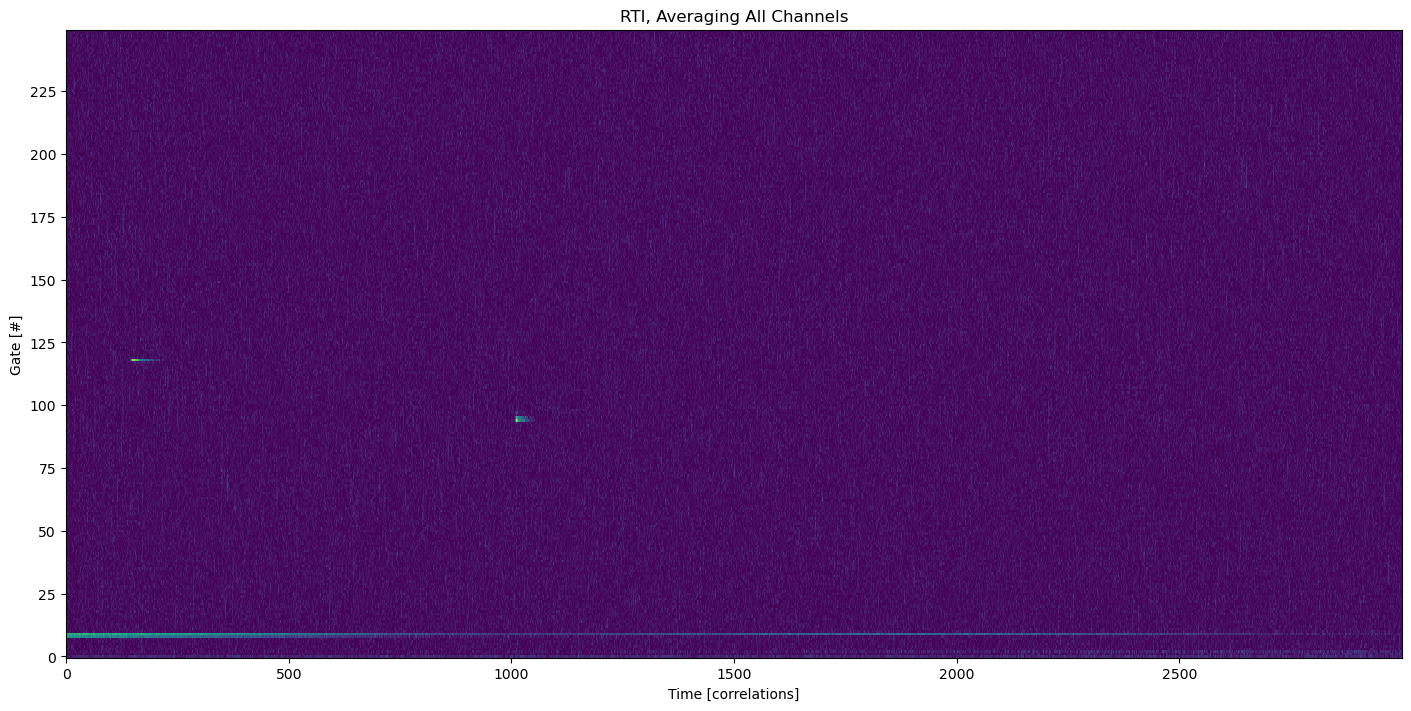

In [240]:
from sklearn.decomposition import PCA

# Performing PCA 
n_ch, n_gates, n_times = rti_array.shape
X = np.moveaxis(rti_array, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA = pca.fit_transform(X)
print(rti_PCA.shape)
rti_PCA = np.reshape(rti_PCA, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot = np.abs(rti_PCA[:, :])
ax.imshow(pca_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

Here both meteors are visible, and the plane is very promminant in the data. Additionaly, some ground interfierence is visible across the first couple of gates. Unfortunately, PCA is slow, and so it's uses for data prep are limited. 


the zephyr repository also includes functions to prepare rti data, similar to PCA in their ability to bring out peaks in data. Unfortunately, the zephyr repository is having issues on my computer, so I have included the function reduce_xarray and a dependnat parse_selection here.

In [241]:
def parse_selection(selection): #Other function from zephyr which I couldn't get to work.
    """
    Parse selection for slices or ranges, with support for 'all' and specific indices or ranges.

    Parameters:
    - selection: Can be 'all', a string for channel names, or a list of indices.
    """
    # If selection is "all", return a slice that selects everything
    if isinstance(selection, str) and selection == "all":
        return slice(None)  # Select all elements
    
    # If selection is a string like "120:-1", handle as a slice
    elif isinstance(selection, str) and ":" in selection:
        try:
            return slice(*map(lambda x: int(x) if x.strip() else None, selection.split(":")))
        except ValueError as e:
            raise ValueError(f"Invalid slice string: '{selection}'. Error: {e}")
    
    # If selection is a list or array of values, return it as-is
    elif isinstance(selection, (list, np.ndarray)):
        return selection
    
    else:
        raise ValueError(f"Invalid selection format: '{selection}'.")

In [242]:
def reduce_xarray(xarray_in, dim_operations, value_agg_func=np.abs): #Function from zephyr that I couldn't get to work
    """
    Reduces the RTI data based on the provided dimension operations (aggregation, selection).
    
    Parameters:
    - dim_operations (dict): Specifies "agg_func" and "selection" for each dimension.
        dim_operations = {
            "tx_rx_channel_pair": {"agg_func": None, "selection": "all"},  # Select polarimetric channels
            "doppler_hz": {"agg_func": None, "selection": [0]},  # Slice specific range
            "gate": {"agg_func": None, "selection": "all"},  # No aggregation
            "time": {"agg_func": None, "selection": "all"}  # Median over specific time slice
            }
    - value_agg_func (callable): Function to transform the data (e.g., np.abs, np.angle).
    
    Returns:
    - reduced_data (numpy.ndarray): Reduced data (2D or 3D) ready for plotting.
    """
    xarray_out = xarray_in.copy()
    xarray_out.attrs =  xarray_in.attrs.copy()
    
    # Apply operations for each dimension
    for dim, operations in dim_operations.items():
        if dim not in xarray_out.dims:
            raise ValueError(f"Dimension '{dim}' not found in data.")

        # Apply selection
        selection = operations.get("selection", "all")
        if dim == "tx_rx_channel_pair" and selection == "polarimetric":
            polarimetric_values = xarray_out.coords['polarimetric_channel'].values
            desired_channels = polarimetric_values[polarimetric_values != None]
            mask = np.isin(polarimetric_values, desired_channels)
            xarray_out = xarray_out.sel(tx_rx_channel_pair=mask)
        else:
            parsed_selection = parse_selection(selection)
            xarray_out = xarray_out.sel({dim: parsed_selection})

        # Apply aggregation if specified
        agg_func = operations.get("agg_func", None)
        if agg_func is not None:
            if not callable(agg_func):
                raise ValueError(f"Aggregation function for '{dim}' must be callable or None.")
            xarray_out = xarray_out.reduce(agg_func, dim=dim, keep_attrs=True)

    # Apply value aggregation function (e.g., np.abs, np.angle)
    if value_agg_func is not None:
        if not callable(value_agg_func):
            raise ValueError("value_agg_func must be a callable function.")
        xarray_out = value_agg_func(xarray_out)
    
    # Modify metadata attributes
    if value_agg_func is not None:
        if 'units' in xarray_out.attrs:
            xarray_out.attrs['units'] = f'{xarray_out.attrs["units"]} ({value_agg_func.__name__})'
        else:
            xarray_out.attrs['units'] = value_agg_func.__name__

    # Return reduced data (converted to numpy array)
    return np.squeeze(xarray_out)


Running the reduce_xarray function results in a 2 dimentional xarray containing only gate and time axies, shown below.

In [243]:
dim_operations = {
                    "tx_rx_channel_pair": {"agg_func": np.std, "selection": "all"},
                    "doppler_hz": {"agg_func": None, "selection": [0]}}
rti_for_det = reduce_xarray(rti_xarray, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository

After being properly formated using reduce_xarray data can be fed into the plane detection algorithm. Other methods such as averaging, or PCA shown above are also valid, with their own benefits and drawbacks, however plane detection requires a 2D xarray (gate like, time like) and will cause errors if given a numpy.array.

# Examples of Algorithm in Use

## Example with Basic Data and basic imports

Here the plane detection algorithm will be run with default settings, on the rti data rti_for_det just discussed. The default settings have already been tuned to work well for a wide variety of RTI data, and will be used if the detect_options dictionary is empty. In this example all three optional graphs are shown, however runtimes will improve when optional graphs are eliminated.

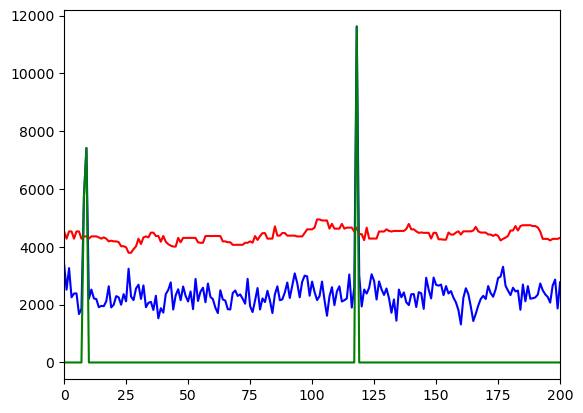

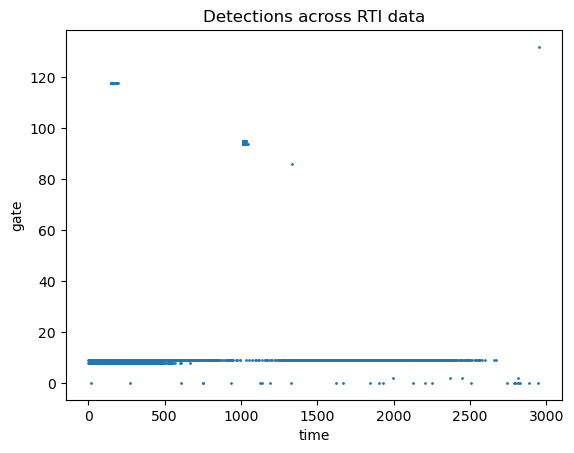

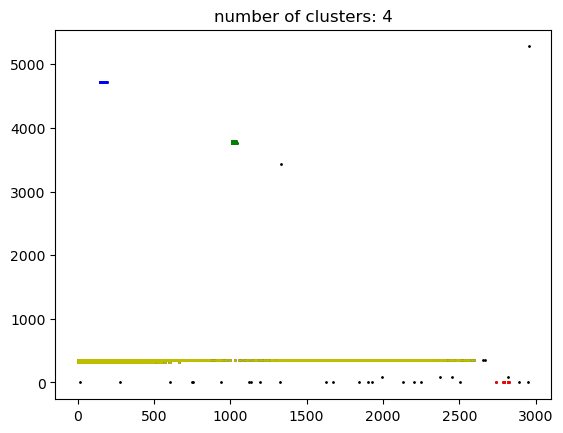

In [244]:
from Plane_Detection import * #Import plane detection algirithm and dependancies
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={},optional_plots=[150,'CFAR_plot','plot_detections',"DBSCAN"])

The first plot, CFAR_plot shows the rti data, targets, and calculated threshold for a single timestamp of data. The timestamp should be specified by entering an integer as the first value of optional_plots. It can be used to help tune the main CFAR algorithm which governs which points are considered targets.

The Second graph shows detection events across the rti data. These are individual points which the  CFAR algorithm labeled as targets, but still could consist as noise, and must still be grouped into objects to be useful.

The third graph shows the data after being passed through the DBSCAN algorithm, which is used to group detections together into detected objects, and eliminate outliers. Each detected object is depicted in a different color. Notice thatt both meteors and the plane are each marked as an object detected. Also note that the detection algorithm marked something in the first gate as an object due to ground interfierence. These detections, and information on them can be seen in the list_dict_proporties value returned.

In [245]:
list_dict_properties

[{'plane_number': 0,
  'max_time': 2597,
  'min_time': 1,
  'max_gate': 9.0,
  'min_gate': 8.0},
 {'plane_number': 1,
  'max_time': 193,
  'min_time': 147,
  'max_gate': 118.0,
  'min_gate': 118.0},
 {'plane_number': 2,
  'max_time': 1047,
  'min_time': 1010,
  'max_gate': 95.0,
  'min_gate': 94.0},
 {'plane_number': 3,
  'max_time': 2828,
  'min_time': 2741,
  'max_gate': 0.0,
  'min_gate': 0.0}]

## Function Inputs and Outputs

    Inputs:
        rti: 
        start_samples: int,
            Initial sample number, used in finding accurate values of sample_number, and 1d_idx
        detect_options: Dict,
            optional detection parameters, when left blank, function will use default tuning
            num_ref_cells: int, 
                number of reference cells
            num_guard_cells: int, 
                number of guard cells
            bias: float, 
                multiplicitive bias to threshold values
            gate_range: int tuple, 
                (min gate, max gate) describing range of rti gates to focus on
            edge_method: string, 
                method used to deal with edges in CFAR algorithm. Options: zero_padding, mean_padding, median_padding, 
                symetric, wrap, mean, median
            method: numpy function,
                cell averaging method used in CFAR algorithm ex: np.mean, np.min. np.max, np.median
            eps: float,
                Radius used in DBSCAN clustering
            min_samples: int,
                minimum number of points in neighborhood to be considered a cluster
            y_scaling: float,
                Scaling factor along y axis, can be used to preevent planes at close altitudes 
                from being identified as a single object
        optional_plots: list,
            [time of interest, 'CFAR_plot','plot_detections','DBSCAN']

    Outputs:
        list_detections: list,
            list of tuples: (gate, time, 1D_idx, sample_number)
        img: returns 0
        list_dict_properties: list,
            list containing dictionaries for each plane detection, with basic information on it
        list_peak_idx_1D: list,
            list of idx_1D for each detection event

## Examples of how changing different values changes detection

Each detection option has drastic effects on how well the algorithm is able to detect meteors. Unfortunately, changing one value in the algorithm often results in needing to adjust other values as well to accomidate, and continue to accurately detect meteors.


### Changing Bias

The bias is the multiplicative bias for threshold values, that is when a threshold value is calculated by averaging reference cells, it is then multiplied by the bias to create a buffer between the threshold and the data. By default the bias has a value of 1.9 but can be changed by specifying "bias" in detect_options. In this case, the bias is lowered from 1.9 to 1.5

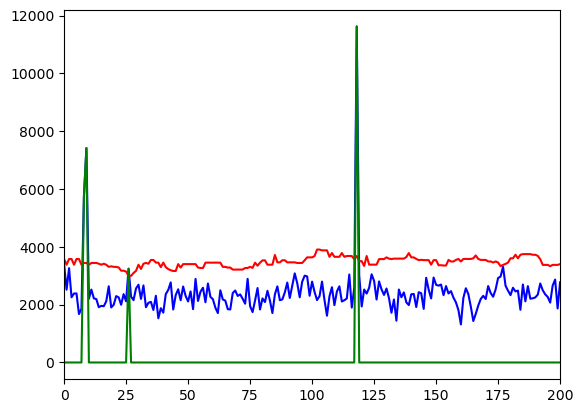

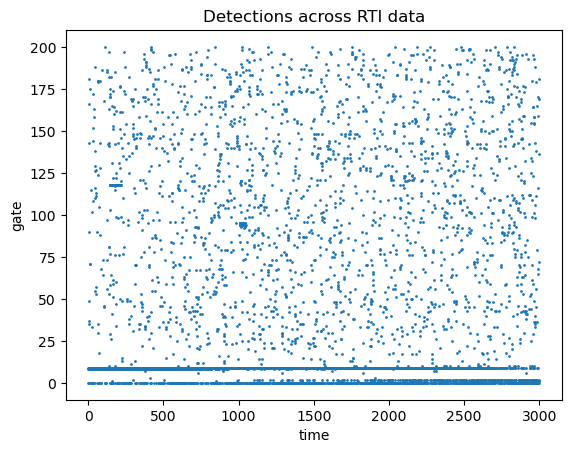

In [246]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"bias":1.5},optional_plots=[150,'CFAR_plot','plot_detections'])

As seen, lowering the bias results in more detections overall. The location of the plane becomes much more prominent, but so does the background noise, and even moreso, the ground interfierience becomes incredibly prominent. Simularly, by increasing the bias reduces the number of false detections, but also can miss legitimate plane detections. 

Changing this value typically necesitates changing the valeus governing DBSCAN, including eps and min_samples

### Changing the Number of Reference Cells


The number of reference cells has a default value of 10. Different reference cell values can be chosen using "num_ref_cells". 

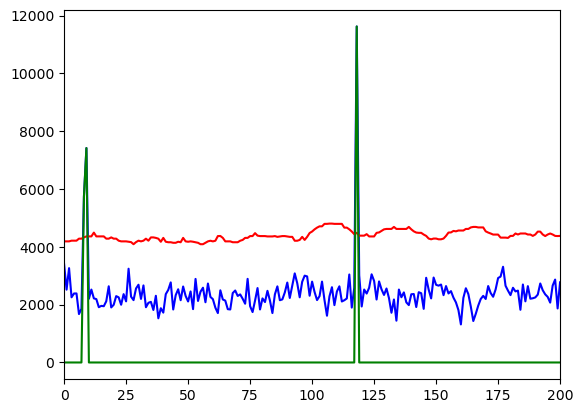

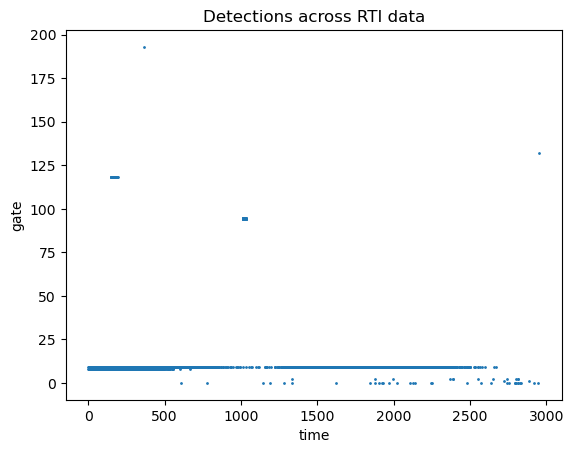

In [247]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"num_ref_cells":20},optional_plots=[150,'CFAR_plot','plot_detections'])

The number of reference cells chosen primarily effects the CFAR part of the algorithm, by adjusting the smoothness of the calculated threshold value. Increasing this value makes it more smooth and liner, while decreasing it causes the threshold to me less consistant. Above, increasing the number of reference cells from 10 to 20 results in more false detections across the rti data.

### method
The method option determines which method is used in determining a threshold value before applying the bias. By default this option is set to np.median, to calculate the median of the reference cells, but can take values such as np.max, np.min, np.mean. Each of these options will significantly effect how noise spikes effect the value of the threshold. In the example below, the method is set to np.max.

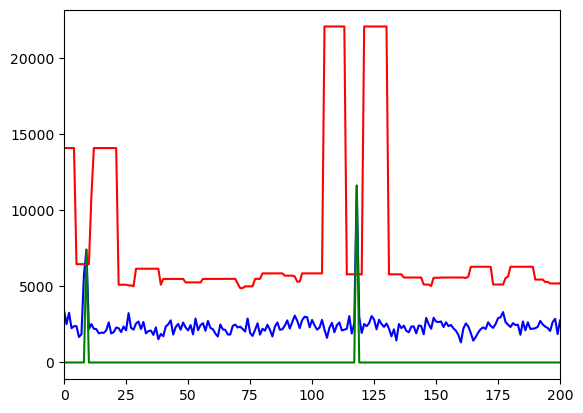

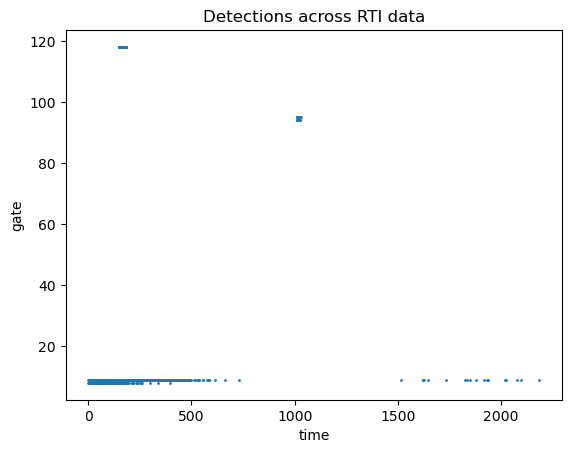

In [248]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"method":np.max},optional_plots=[150,'CFAR_plot','plot_detections'])

Changing the method used to calculate the threshold value both effects the data that is considered a target or not, as well as the coputation time required. This sometimes means trading speed for accuracy.

### Changing eps
eps, or epsilon represents the distance away from an individual point which another point cah be and still be considered in the same neighborhood. This essentially determines how far individual detections can be away from each other to be considered the same object. By default this value is set to 55, but in this example is is reduced to 10.

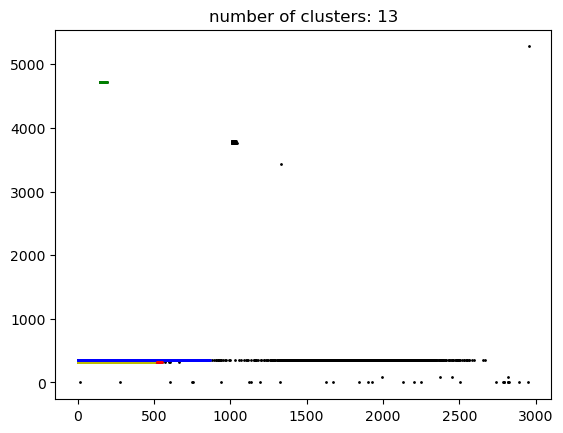

In [249]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"eps":10},optional_plots=['DBSCAN'])

Reducing the eps significantly increases the number of clusters or objects the detection algorithm determines there to be. Due to there being smaller neiborhoods points that would otherwise be clasified as the same object are not.

Additionally, since the value of y_scaling is 40, and greater than the value of eps in this example, the algorithm determines that detections across different range gates are seperate objects. Because of this, the ratio eps/y_scaling can very greatly effect the accuracy of the algorithm. I have found that eps/y_scaling should be around 1-2. This allows the algorithm to group detections across two seperate gates as one object, while preventing objects in significantly different range gates from being clumped as the same object.

## Examples with different datasets

In addition to tuning parameters, the types of planes, and other objects observed can influence the quality of detection, and what it looks like. Cases when this causes a failure are shown below.




### One with "Faiding" plane

Many planes exibit a fading pattern, in which they become more or less pronounced over a period. In the case of planes with a small period, the default settings work very well.

In [250]:
file_name2 = 'RTI_faiding_plane_15s.rti' #Load in rti with fading plane
with open(f'{data_dir}/{file_name2}', "rb") as f:
        rti_xarray_faidingplane = pickle.load(f)

For ease of visualization, a PCA plot of such a plane is shown.

(750000, 1)


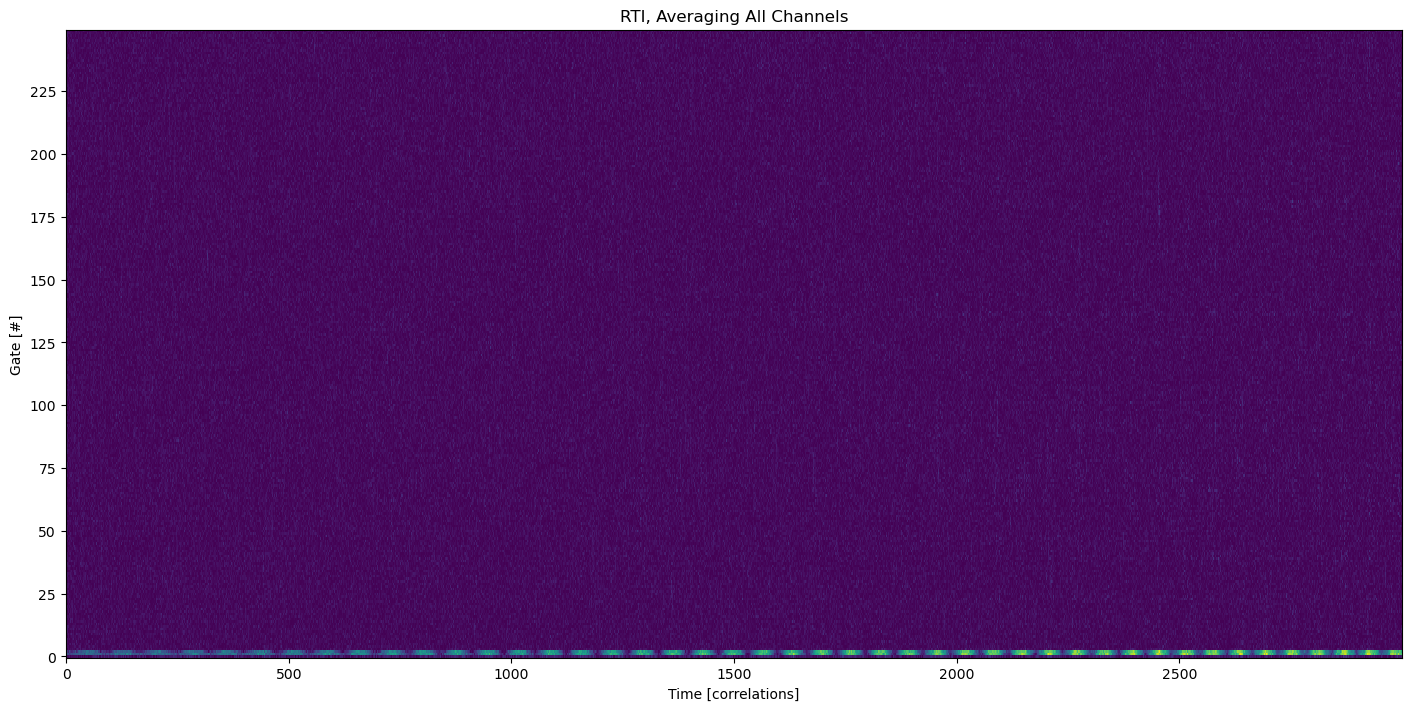

In [251]:
rti_array_faidingplane = rti_xarray_faidingplane.values[:, 0, :250, :]
# Performing PCA 
n_ch, n_gates, n_times = rti_array_faidingplane.shape
X = np.moveaxis(rti_array_faidingplane, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA_faidingplane = pca.fit_transform(X)
print(rti_PCA_faidingplane.shape)
rti_PCA_faidingplane = np.reshape(rti_PCA_faidingplane, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot_faidingplane = np.abs(rti_PCA_faidingplane[:, :])
ax.imshow(pca_for_plot_faidingplane, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

Running the plane detection algorithm on a plane like this with a short period is very effective, especially when the noise background is minimal.

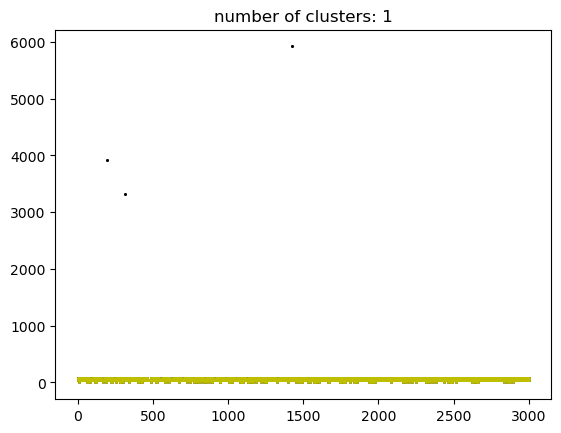

In [252]:
rti_for_det_faidingplane = reduce_xarray(rti_xarray_faidingplane, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det_faidingplane,start_samples=2000,detect_options={},optional_plots=['DBSCAN'])

In this example, the plane detection algorithm was able to pick out the location of the plane for the entire 15s of rti data provided. The short intervals are well within the value of eps, and so the algorithm is easily able to pick out a single plane, despite the period in it's signal. Planes where this fails to work, and possible corrections are discussed later on.

### Spikes in Background Noise


Smaller spikes in background noise with time, are also unproblematic for the algorithm. Since CFAR works only on individual timestamps, and is based off of the noise floor, smaller increases and decreses of 

In [253]:
file_name3 = 'RTI_mild_background_noise_15s.rti'
with open(f'{data_dir}/{file_name3}', "rb") as f:
        rti_xarray_backgroundinterfierence = pickle.load(f)

(750000, 1)


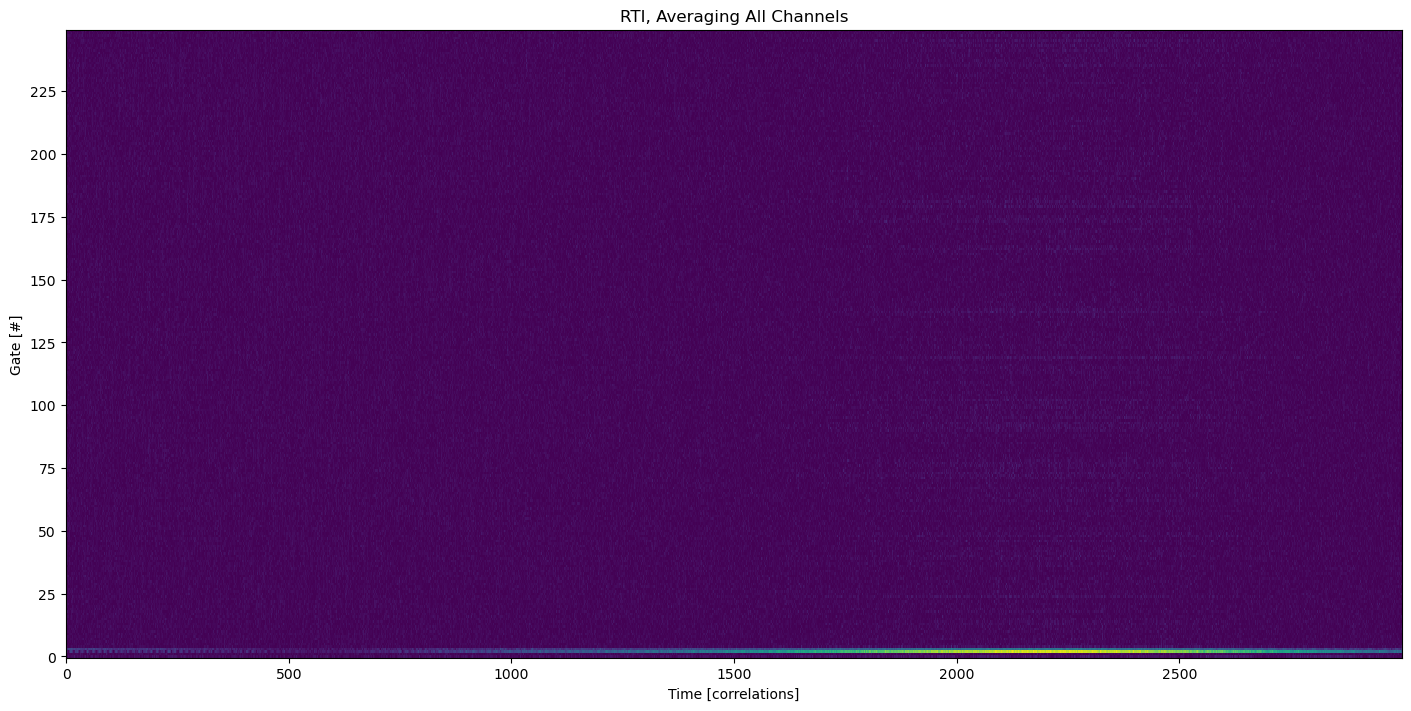

In [254]:
rti_array_backgroundinterfierence = rti_xarray_backgroundinterfierence.values[:, 0, :250, :]
# Performing PCA 
n_ch, n_gates, n_times = rti_array_backgroundinterfierence.shape
X = np.moveaxis(rti_array_backgroundinterfierence, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA_backgroundinterfierence = pca.fit_transform(X)
print(rti_PCA_backgroundinterfierence.shape)
rti_PCA_backgroundinterfierence = np.reshape(rti_PCA_backgroundinterfierence, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot_backgroundinterfierence = np.abs(rti_PCA_backgroundinterfierence[:, :])
ax.imshow(pca_for_plot_backgroundinterfierence, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

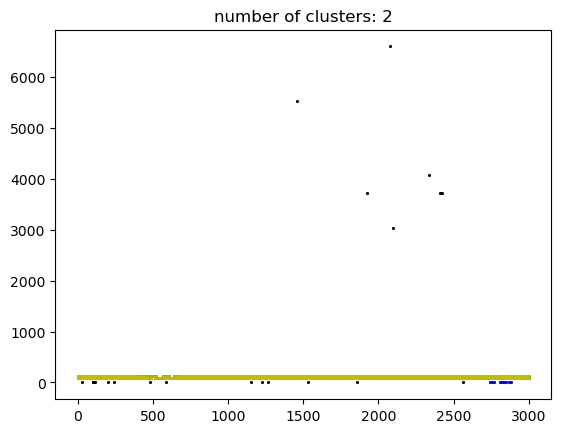

In [255]:
rti_for_det_backgroundinterfierence = reduce_xarray(rti_xarray_backgroundinterfierence, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det_backgroundinterfierence,start_samples=2000,detect_options={},optional_plots=['DBSCAN'])

# Known issues, or inconsistancies with the algorithm

### Problems with noise spikes

In [256]:
file_name3 = 'RTI_zephyrtx3_zephyrrx2_1678326201_15s.rti'
with open(f'{data_dir}/{file_name3}', "rb") as f:
        rti_xarray_backgroundinterfierence2 = pickle.load(f)

(750000, 1)


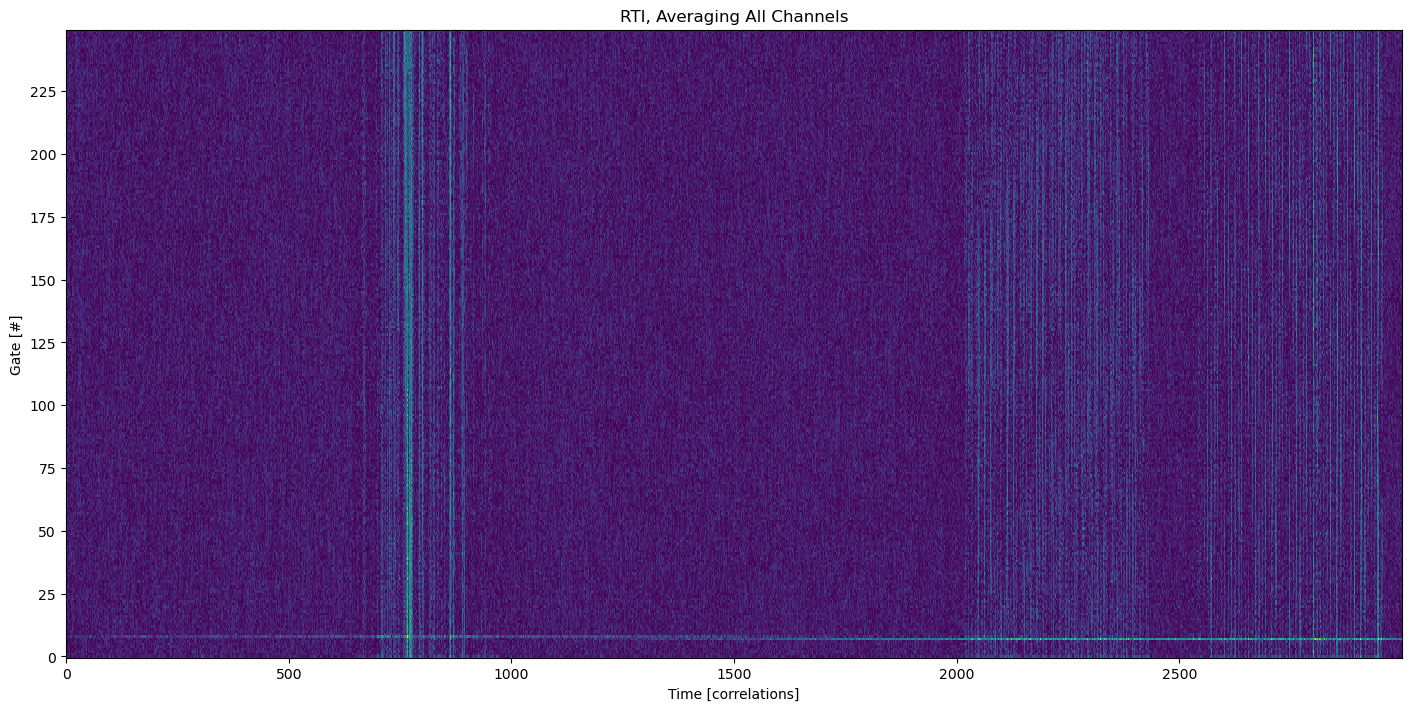

In [257]:
rti_array_backgroundinterfierence2 = rti_xarray_backgroundinterfierence2.values[:, 0, :250, :]
# Performing PCA 
n_ch, n_gates, n_times = rti_array_backgroundinterfierence2.shape
X = np.moveaxis(rti_array_backgroundinterfierence2, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA_backgroundinterfierence2 = pca.fit_transform(X)
print(rti_PCA_backgroundinterfierence2.shape)
rti_PCA_backgroundinterfierence2 = np.reshape(rti_PCA_backgroundinterfierence2, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot_backgroundinterfierence2 = np.abs(rti_PCA_backgroundinterfierence2[:, :])
ax.imshow(pca_for_plot_backgroundinterfierence2, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

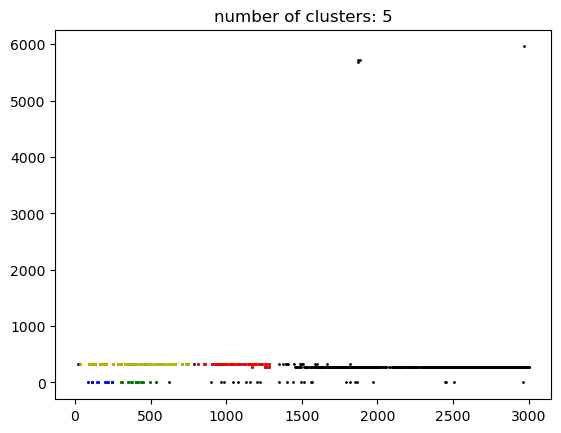

In [258]:
rti_for_det_backgroundinterfierence2 = reduce_xarray(rti_xarray_backgroundinterfierence2, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det_backgroundinterfierence2,start_samples=2000,detect_options={},optional_plots=['DBSCAN'])

### Ground Interfierence

In [259]:
file_name4 = 'RTI_zephyrtx3_zephyrrx2_1678338621_15s.rti'
with open(f'{data_dir}/{file_name4}', "rb") as f:
        rti_xarray_groundinterfierence = pickle.load(f)

(750000, 1)


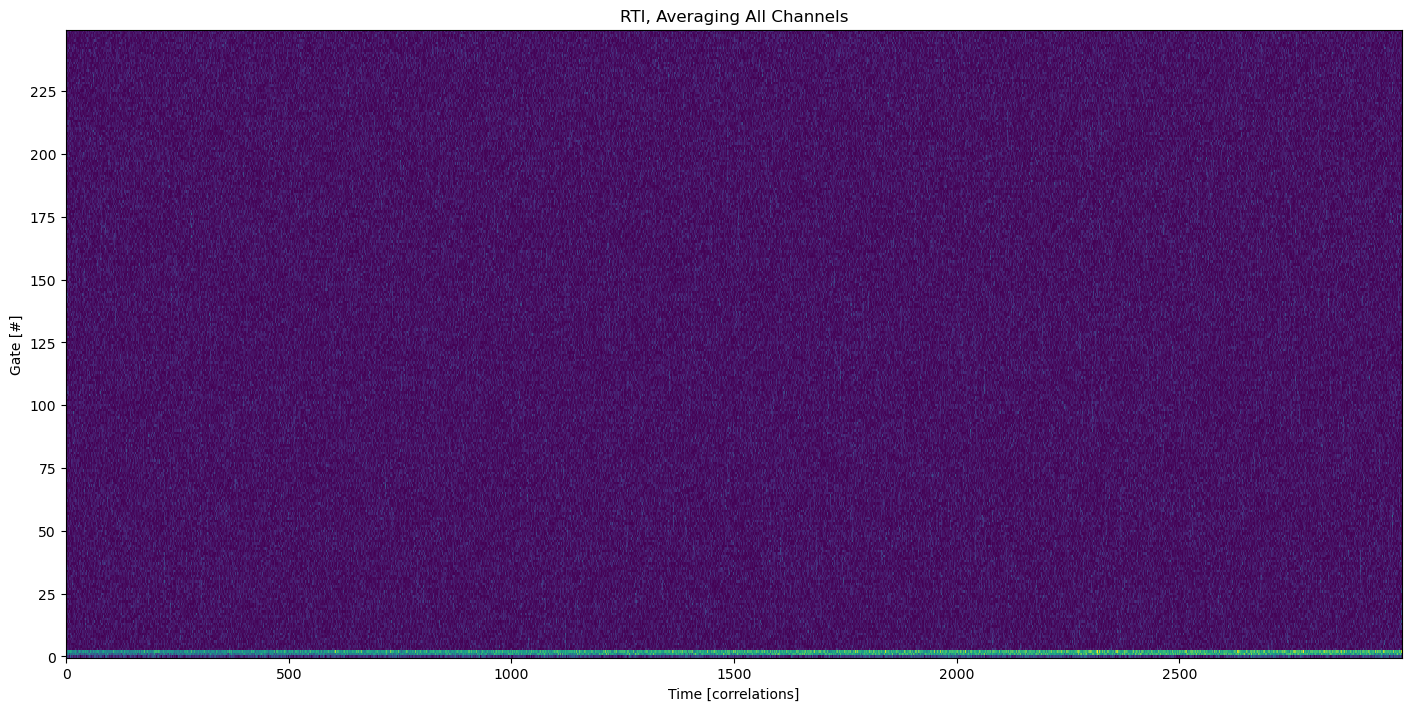

In [260]:
rti_array_groundinterfierence = rti_xarray_groundinterfierence.values[:, 0, :250, :]
# Performing PCA 
n_ch, n_gates, n_times = rti_array_groundinterfierence.shape
X = np.moveaxis(rti_array_groundinterfierence, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA_groundinterfierence = pca.fit_transform(X)
print(rti_PCA_groundinterfierence.shape)
rti_PCA_groundinterfierence = np.reshape(rti_PCA_groundinterfierence, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot_groundinterfierence = np.abs(rti_PCA_groundinterfierence[:, :])
ax.imshow(pca_for_plot_groundinterfierence, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

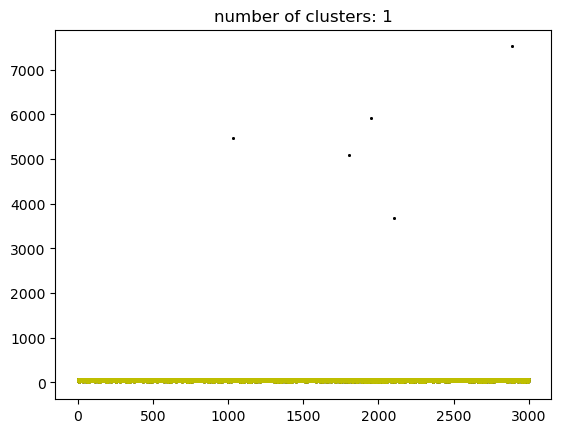

In [261]:
rti_for_det_groundinterfierence = reduce_xarray(rti_xarray_groundinterfierence, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det_groundinterfierence,start_samples=2000,detect_options={},optional_plots=['DBSCAN'])

# Other Resources / other useful resources

# Further work